
# **卷積神經網路 (Convolutional Neural Network, CNN)**
(請在coloab上使用)

In [39]:
# @title **🔧 環境準備（Colab / 本機皆可）**
import importlib, sys, subprocess

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for pkg in ["numpy", "matplotlib", "scikit-learn", "torch"]:
    try:
        importlib.import_module(pkg if pkg != "scikit-learn" else "sklearn")
    except:
        pip_install(pkg)

import numpy as np
import matplotlib.pyplot as plt
import torch

plt.rcParams["figure.dpi"] = 120

<br>

## **1. 電腦眼中的「圖片」是什麼？**

在電腦裡：  

👉 **圖片其實是一個數字表格（矩陣）**

- 每一個格子 = 一個像素（pixel）
- 數字大小 = 亮度（灰階）或顏色強度


先用一張「超小圖片」來看。

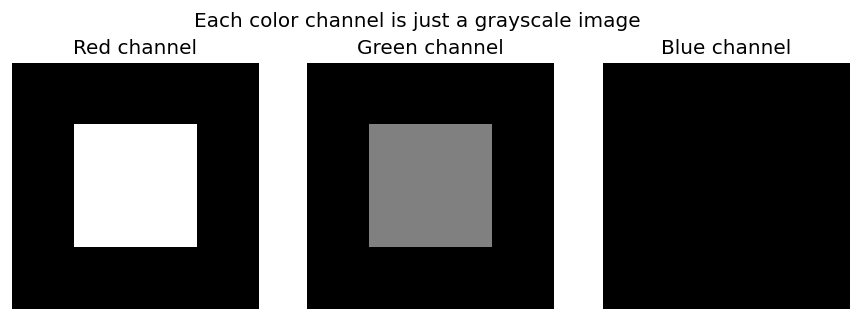

In [40]:
# @title **三原色通道**
import numpy as np
import matplotlib.pyplot as plt

BASE_IMG = np.zeros((8,8,3))
BASE_IMG[2:6,2:6] = [1, 0.5, 0]   # 橘色方塊

fig, axes = plt.subplots(1, 3, figsize=(9,3))

channels = ["Red channel", "Green channel", "Blue channel", "Color"]

for i, ax in enumerate(axes):
    ax.imshow(BASE_IMG[:,:,i], cmap="gray", vmin=0, vmax=1)
    ax.set_title(channels[i])
    ax.axis("off")

plt.suptitle("Each color channel is just a grayscale image")
plt.show()


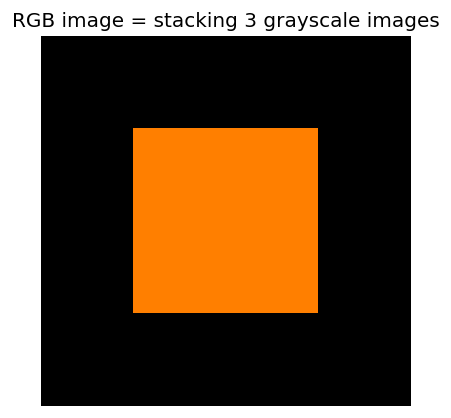

In [ ]:
# @title **彩色影像**
plt.figure(figsize=(4,4))
plt.imshow(BASE_IMG)
plt.title("RGB image = stacking 3 grayscale images")
plt.axis("off")
plt.show()

In [41]:
# @title **像素值**
y, x = 3, 3
pixel = BASE_IMG[y, x]

print(f"Pixel at (y={y}, x={x})")
print("RGB vector =", pixel)


Pixel at (y=3, x=3)
RGB vector = [1.  0.5 0. ]


In [42]:
print("Red channel matrix:")
print(BASE_IMG[:,:,0])

print("\nGreen channel matrix:")
print(BASE_IMG[:,:,1])

print("\nBlue channel matrix:")
print(BASE_IMG[:,:,2])


Red channel matrix:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

Green channel matrix:
[[0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5 0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5 0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5 0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]

Blue channel matrix:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


<br>

## **2. CNN由來**

如果我們用 **傳統全連接神經網路（Dense）** 來看圖片：

- 一張 64×64 圖片 = **4096 個輸入**
- 參數很多 👉 很容易爆炸 💥
- 邊緣、形狀這些「局部特徵」會被忽略

👉 所以我們需要一個：  
**「會看局部、會重複使用同一組規則」的模型**

---

### **生物啟發：人類是怎麼「看」的？**

科學家在研究人類與動物視覺皮層時發現：

- 👁️ 眼睛不是一次看完整畫面
- 🧩 大腦是「先看小區域」
- 🔁 同一種「找線條的方法」會在不同位置重複使用

👉 這個發現來自 **Hubel & Wiesel（1960s）**  
他們發現：
- 有些神經元專門對「水平線」有反應  
- 有些對「垂直線」有反應  

這正是 **CNN kernel 的靈感來源**。

---

### ✨ CNN 的突破（LeNet-5）

1998 年，Yann LeCun 發表 **LeNet-5**：

- 用小視窗（kernel）掃描圖片
- 同一組權重在整張圖上重複使用
- 先找「線條、邊緣」，再組成「數字、形狀」

👉 這套設計，成為 **今天所有 CNN 的祖先**。

> **CNN = 用小視窗在圖片上滑動，找重複出現的圖形特徵**

<br>


## **3. CNN 在做什麼？**

```
圖片
 ↓
Conv → ReLU
 ↓
Pooling
 ↓
Conv → ReLU
 ↓
Pooling
 ↓
Flatten
 ↓
全連接層
 ↓
分類結果
```

👉 前面負責「看圖找特徵」  
👉 後面負責「根據特徵做判斷」

<br>

## **4. 卷積層 (Convolution layer)**

- 🔍 拿一個小方塊（kernel / filter）

- 🔍 在圖片上「從左到右，從上到下滑過去」

- 🔍 每次只看一小塊（局部）

- 🔍 找出「常出現的形狀或顏色組合」

<br>

### **a. kernel（濾鏡）**

```text
[ 1   0  -1]
[ 1   0  -1]
[ 1   0  -1]
```

這個 kernel 可以想成在問：

> **「這裡是不是有『左邊比較暗、右邊比較亮』的垂直邊緣？」**

```text
[ 1   1   1 ]
[ 0   0   0 ]
[-1  -1  -1 ]
```

這個 kernel 可以想成在問：

> **「這裡是不是有『上面比較亮、下面比較暗』的水平邊緣？」**



<br>

### **b. Kernel 在圖像做卷積滑動**

In [ ]:
# @title **卷積滑動**
from ipywidgets import interact, IntSlider

# 6x6 "image" (照你圖上的數字)
img = np.array([
    [3, 0, 1, 2, 7, 4],
    [1, 5, 8, 9, 3, 1],
    [2, 7, 2, 5, 1, 3],
    [0, 1, 3, 1, 7, 8],
    [4, 2, 1, 6, 2, 8],
    [2, 4, 5, 2, 3, 9],
], dtype=float)

# 3x3 filter (照你圖上：每列 [1,0,-1])
kernel = np.array([
    [ 1, 0,-1],
    [ 1, 0,-1],
    [ 1, 0,-1],
], dtype=float)

kh, kw = kernel.shape
out_h, out_w = img.shape[0] - kh + 1, img.shape[1] - kw + 1

import numpy as np
import matplotlib.pyplot as plt

def draw_numbers_on_imshow(ax, M, fmt="{:.0f}"):
    """
    在 ax.imshow(M) 之後呼叫。
    會根據顏色深淺自動用白字/黑字，避免看不到。
    """
    # 取得目前 ax imshow 用的 colormap 與 normalization
    im = ax.images[-1]
    cmap = im.get_cmap()
    norm = im.norm

    for (r, c), val in np.ndenumerate(M):
        if np.isnan(val):
            continue

        # 把數值映射到顏色 (RGBA)
        rgba = cmap(norm(val))
        # 計算亮度（越大越亮）
        luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        text_color = "black" if luminance > 0.6 else "white"

        ax.text(c, r, fmt.format(val), ha="center", va="center",
                color=text_color, fontsize=12, fontweight="bold")

def step_view(step=0):
    # step -> (i, j)
    i = step // out_w
    j = step %  out_w

    patch = img[i:i+kh, j:j+kw]
    mul = patch * kernel
    s = np.sum(mul)

    # 做一個「目前算到哪」的 feature map（其他先留空 NaN）
    partial = np.full((out_h, out_w), np.nan)
    for t in range(step+1):
        ti = t // out_w
        tj = t %  out_w
        partial[ti, tj] = np.sum(img[ti:ti+kh, tj:tj+kw] * kernel)

    # 畫圖
    fig = plt.figure(figsize=(14,4))
    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
    ax3 = plt.subplot(1,4,3)
    ax4 = plt.subplot(1,4,4)

    # 1) 原圖 + 框出目前 patch 範圍
    ax1.imshow(img, cmap="viridis")
    ax1.set_title(f"Image (patch at i={i}, j={j})")
    ax1.set_xticks([])
    ax1.set_yticks([])
    for (r, c), val in np.ndenumerate(img):
        ax1.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=11)

    # 畫紅框
    rect = plt.Rectangle((j-0.5, i-0.5), kw, kh, fill=False, edgecolor="red", linewidth=3)
    ax1.add_patch(rect)

    # 2) patch
    ax2.imshow(patch, cmap="viridis")
    ax2.set_title("Patch")
    ax2.set_xticks([])
    ax2.set_yticks([])
    for (r, c), val in np.ndenumerate(patch):
        ax2.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=12)

    # 3) kernel
    ax3.imshow(kernel, cmap="viridis")
    ax3.set_title(f"Kernel (sum={s:.0f})")
    ax3.set_xticks([])
    ax3.set_yticks([])
    for (r, c), val in np.ndenumerate(kernel):
        ax3.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=12)

    # 4) partial feature map
    ax4.imshow(partial, cmap="viridis")
    ax4.set_title("Feature Map (computed so far)")
    ax4.set_xticks([])
    ax4.set_yticks([])

    ax4.imshow(partial, cmap="viridis")  # 你也可以換 "gray" 或 "cividis"
    draw_numbers_on_imshow(ax4, partial, fmt="{:.0f}")

    # 標示目前要填的格子
    ax4.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor="red", linewidth=3))

    plt.tight_layout()
    plt.show()

interact(step_view, step=IntSlider(min=0, max=out_h*out_w-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='step', max=15), Output()), _dom_classes=('widget-interac…

<function __main__.step_view(step=0)>

<br>

### **c. Kernel 邊緣偵測**

- 圖片從窗口切一小塊（patch）
- 跟 kernel 一格一格相乘
- 全部加起來 → 得到一個數字

**很像 kernel 的 patch**
  - 乘起來幾乎都在「加分」
  - 👉 數值會變得很大

**有點像的 patch**
  - 有些地方加分、有些地方普通
  - 👉 數值中等

**不像的 patch**
  - 正負亂七八糟、彼此抵消
  - 👉 數值接近 0，甚至是負的


> **Kernel 就像一張「形狀模板」**  
> 當它滑到「很像自己要找的特徵」時，算出來的數值會 **很大**；  
> 滑到「不像的地方」，數值就會 **很小，甚至是負的**。

#### **垂直邊緣**

```text
[ 1   0  -1]
[ 1   0  -1]
[ 1   0  -1]
```

這個 kernel 可以想成在問：

> **「這裡是不是有『左邊比較暗、右邊比較亮』的垂直邊緣？」**

In [ ]:
# @title **垂直Demo**
from ipywidgets import interact, IntSlider

# 6x6 "image" (照你圖上的數字)
img = np.array([
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
    [10, 10, 10, 0, 0, 0],
], dtype=float)

# 3x3 filter (照你圖上：每列 [1,0,-1])
kernel = np.array([
    [ 1, 0,-1],
    [ 1, 0,-1],
    [ 1, 0,-1],
], dtype=float)

kh, kw = kernel.shape
out_h, out_w = img.shape[0] - kh + 1, img.shape[1] - kw + 1

import numpy as np
import matplotlib.pyplot as plt

def draw_numbers_on_imshow(ax, M, fmt="{:.0f}"):
    """
    在 ax.imshow(M) 之後呼叫。
    會根據顏色深淺自動用白字/黑字，避免看不到。
    """
    # 取得目前 ax imshow 用的 colormap 與 normalization
    im = ax.images[-1]
    cmap = im.get_cmap()
    norm = im.norm

    for (r, c), val in np.ndenumerate(M):
        if np.isnan(val):
            continue

        # 把數值映射到顏色 (RGBA)
        rgba = cmap(norm(val))
        # 計算亮度（越大越亮）
        luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        text_color = "black" if luminance > 0.6 else "white"

        ax.text(c, r, fmt.format(val), ha="center", va="center",
                color=text_color, fontsize=12, fontweight="bold")

def step_view(step=0):
    # step -> (i, j)
    i = step // out_w
    j = step %  out_w

    patch = img[i:i+kh, j:j+kw]
    mul = patch * kernel
    s = np.sum(mul)

    # 做一個「目前算到哪」的 feature map（其他先留空 NaN）
    partial = np.full((out_h, out_w), np.nan)
    for t in range(step+1):
        ti = t // out_w
        tj = t %  out_w
        partial[ti, tj] = np.sum(img[ti:ti+kh, tj:tj+kw] * kernel)

    # 畫圖
    fig = plt.figure(figsize=(14,4))
    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
    ax3 = plt.subplot(1,4,3)
    ax4 = plt.subplot(1,4,4)

    # 1) 原圖 + 框出目前 patch 範圍
    ax1.imshow(img, cmap="gray")
    ax1.set_title(f"Image (patch at i={i}, j={j})")
    ax1.set_xticks([])
    ax1.set_yticks([])
    for (r, c), val in np.ndenumerate(img):
        ax1.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=11)

    # 畫紅框
    rect = plt.Rectangle((j-0.5, i-0.5), kw, kh, fill=False, edgecolor="red", linewidth=3)
    ax1.add_patch(rect)

    # 2) patch
    ax2.imshow(patch, cmap="gray")
    ax2.set_title("Patch")
    ax2.set_xticks([])
    ax2.set_yticks([])
    for (r, c), val in np.ndenumerate(patch):
        ax2.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=12)

    # 3) kernel
    ax3.imshow(kernel, cmap="gray")
    ax3.set_title(f"Kernel (sum={s:.0f})")
    ax3.set_xticks([])
    ax3.set_yticks([])
    for (r, c), val in np.ndenumerate(kernel):
        ax3.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=12)

    # 4) partial feature map
    ax4.imshow(partial, cmap="gray")
    ax4.set_title("Feature Map (computed so far)")
    ax4.set_xticks([])
    ax4.set_yticks([])

    ax4.imshow(partial, cmap="gray")  # 你也可以換 "gray" 或 "cividis"
    draw_numbers_on_imshow(ax4, partial, fmt="{:.0f}")

    # 標示目前要填的格子
    ax4.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor="red", linewidth=3))

    plt.tight_layout()
    plt.show()

interact(step_view, step=IntSlider(min=0, max=out_h*out_w-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='step', max=15), Output()), _dom_classes=('widget-interac…

<function __main__.step_view(step=0)>

<br>

#### **水平邊緣**

```text
[ 1   1   1 ]
[ 0   0   0 ]
[-1  -1  -1 ]
```

這個 kernel 可以想成在問：

> **「這裡是不是有『上面比較亮、下面比較暗』的水平邊緣？」**

In [ ]:
# @title **水平Demo**
from ipywidgets import interact, IntSlider

# 6x6 "image" (照你圖上的數字)
img = np.array([
    [10, 10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10, 10],
    [0,   0,  0,  0,  0,  0],
    [0,   0,  0,  0,  0,  0],
    [0,   0,  0,  0,  0,  0],
], dtype=float)

# 3x3 filter (照你圖上：每列 [1,0,-1])
kernel = np.array([
    [ 1,  1, 1],
    [ 0,  0, 0],
    [-1, -1,-1],
], dtype=float)

kh, kw = kernel.shape
out_h, out_w = img.shape[0] - kh + 1, img.shape[1] - kw + 1

import numpy as np
import matplotlib.pyplot as plt

def draw_numbers_on_imshow(ax, M, fmt="{:.0f}"):
    """
    在 ax.imshow(M) 之後呼叫。
    會根據顏色深淺自動用白字/黑字，避免看不到。
    """
    # 取得目前 ax imshow 用的 colormap 與 normalization
    im = ax.images[-1]
    cmap = im.get_cmap()
    norm = im.norm

    for (r, c), val in np.ndenumerate(M):
        if np.isnan(val):
            continue

        # 把數值映射到顏色 (RGBA)
        rgba = cmap(norm(val))
        # 計算亮度（越大越亮）
        luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        text_color = "black" if luminance > 0.6 else "white"

        ax.text(c, r, fmt.format(val), ha="center", va="center",
                color=text_color, fontsize=12, fontweight="bold")

def step_view(step=0):
    # step -> (i, j)
    i = step // out_w
    j = step %  out_w

    patch = img[i:i+kh, j:j+kw]
    mul = patch * kernel
    s = np.sum(mul)

    # 做一個「目前算到哪」的 feature map（其他先留空 NaN）
    partial = np.full((out_h, out_w), np.nan)
    for t in range(step+1):
        ti = t // out_w
        tj = t %  out_w
        partial[ti, tj] = np.sum(img[ti:ti+kh, tj:tj+kw] * kernel)

    # 畫圖
    fig = plt.figure(figsize=(14,4))
    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
    ax3 = plt.subplot(1,4,3)
    ax4 = plt.subplot(1,4,4)

    # 1) 原圖 + 框出目前 patch 範圍
    ax1.imshow(img, cmap="gray")
    ax1.set_title(f"Image (patch at i={i}, j={j})")
    ax1.set_xticks([])
    ax1.set_yticks([])
    for (r, c), val in np.ndenumerate(img):
        ax1.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=11)

    # 畫紅框
    rect = plt.Rectangle((j-0.5, i-0.5), kw, kh, fill=False, edgecolor="red", linewidth=3)
    ax1.add_patch(rect)

    # 2) patch
    ax2.imshow(patch, cmap="gray")
    ax2.set_title("Patch")
    ax2.set_xticks([])
    ax2.set_yticks([])
    for (r, c), val in np.ndenumerate(patch):
        ax2.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=12)

    # 3) kernel
    ax3.imshow(kernel, cmap="gray")
    ax3.set_title(f"Kernel (sum={s:.0f})")
    ax3.set_xticks([])
    ax3.set_yticks([])
    for (r, c), val in np.ndenumerate(kernel):
        ax3.text(c, r, f"{val:.0f}", ha="center", va="center", color="black", fontsize=12)

    # 4) partial feature map
    ax4.imshow(partial, cmap="gray")
    ax4.set_title("Feature Map (computed so far)")
    ax4.set_xticks([])
    ax4.set_yticks([])

    ax4.imshow(partial, cmap="gray")  # 你也可以換 "gray" 或 "cividis"
    draw_numbers_on_imshow(ax4, partial, fmt="{:.0f}")

    # 標示目前要填的格子
    ax4.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor="red", linewidth=3))

    plt.tight_layout()
    plt.show()

interact(step_view, step=IntSlider(min=0, max=out_h*out_w-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='step', max=15), Output()), _dom_classes=('widget-interac…

<function __main__.step_view(step=0)>

<br>


### **d. 一個 Kernel ≠ 一個答案**

CNN 會同時使用 **很多個 kernel**：

- 有的找「直線」
- 有的找「角落」
- 有的找「顏色變化」

👉 每個 kernel 都會產生一張 **Feature Map**


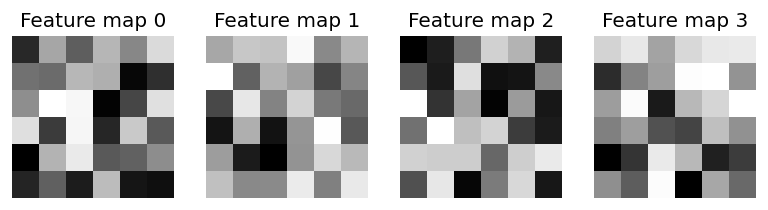

In [ ]:
# @title **模擬多個 feature maps（用不同顏色表示）**
feature_maps = np.random.rand(6,6,4)

fig = plt.figure(figsize=(8,4))
for i in range(4):
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(feature_maps[:,:,i], cmap="gray")
    ax.set_title(f"Feature map {i}")
    ax.axis("off")

plt.show()


<br>

## **5. ReLU 層：為什麼 CNN 需要「把負數變 0」？**

在前面我們看到：  
👉 **卷積的結果可能是正數、0、也可能是負數**

那問題來了：

> 這些「負數」對影像辨識有幫助嗎？

所以:
> 不重要的訊號直接丟掉，重要的留下來

數學寫法其實很簡單：

```
ReLU(x) = max(0, x)
```

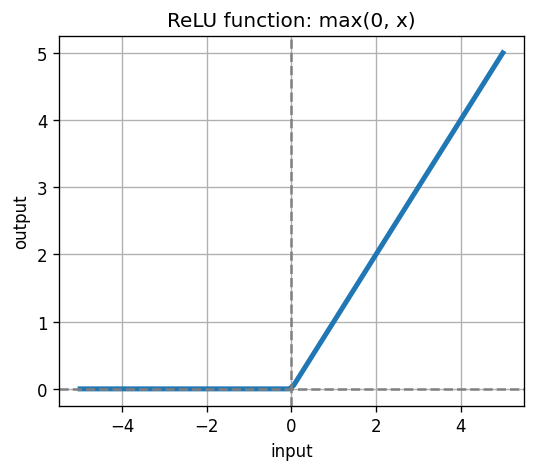

In [ ]:
# @title **ReLu函式圖**
x = np.linspace(-5, 5, 100)
y = np.maximum(0, x)

plt.figure(figsize=(5,4))
plt.plot(x, y, linewidth=3)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.title("ReLU function: max(0, x)")
plt.xlabel("input")
plt.ylabel("output")
plt.grid(True)
plt.show()

### 👀 用影像直覺來理解 ReLU

- 正數 👉「這裡很像 kernel 在找的特徵」  
- 負數 👉「方向相反或雜訊」

👉 **ReLU 會把不像的地方直接關掉（變成 0）**，  
只留下值得後面層繼續使用的訊號。

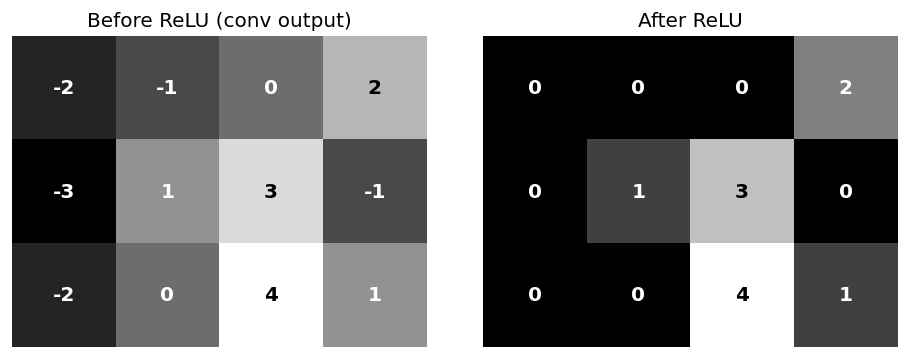

In [ ]:
# @title **ReLu前後變化模擬圖**
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Data
# -----------------------------
conv_output = np.array([
    [-2, -1,  0,  2],
    [-3,  1,  3, -1],
    [-2,  0,  4,  1],
], dtype=float)

relu_output = np.maximum(0, conv_output)

# -----------------------------
# Helper: draw numbers on pixels
# -----------------------------
def draw_values(ax, M, fmt="{:.0f}"):
    im = ax.images[-1]
    cmap = im.get_cmap()
    norm = im.norm

    for (r, c), val in np.ndenumerate(M):
        rgba = cmap(norm(val))
        # perceived luminance
        luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        text_color = "black" if luminance > 0.6 else "white"

        ax.text(
            c, r, fmt.format(val),
            ha="center", va="center",
            color=text_color,
            fontsize=12, fontweight="bold"
        )

# -----------------------------
# Plot
# -----------------------------
fig = plt.figure(figsize=(8,3))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(conv_output, cmap="gray")
ax1.set_title("Before ReLU (conv output)")
ax1.axis("off")
draw_values(ax1, conv_output)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(relu_output, cmap="gray")
ax2.set_title("After ReLU")
ax2.axis("off")
draw_values(ax2, relu_output)

plt.tight_layout()
plt.show()


<br>


## **6. Pooling：留下重點，其它不管**

Pooling 就像：
- 📸 把照片縮小
- 👀 但人還是看得出重點

下面用 **顏色深淺** 來表示 Max Pooling。


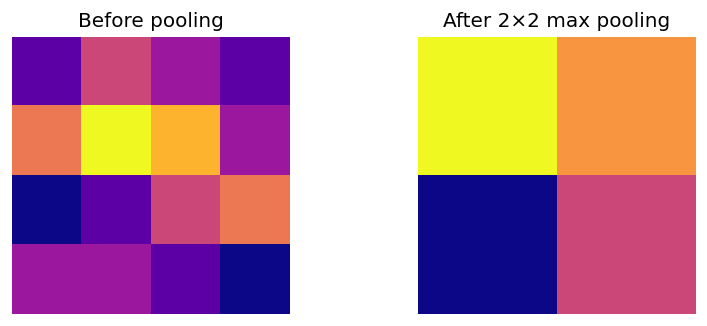

In [ ]:
# @title **示意圖1**
x = np.array([
    [1, 3, 2, 1],
    [4, 6, 5, 2],
    [0, 1, 3, 4],
    [2, 2, 1, 0]
], dtype=float)

pooled = np.array([
    [x[0:2,0:2].max(), x[0:2,2:4].max()],
    [x[2:4,0:2].max(), x[2:4,2:4].max()]
])

fig = plt.figure(figsize=(8,3))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(x, cmap="plasma")
ax1.set_title("Before pooling")
ax1.axis("off")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(pooled, cmap="plasma")
ax2.set_title("After 2×2 max pooling")
ax2.axis("off")

plt.show()


In [44]:
# @title **示意圖2**
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown

# -----------------------------
# Demo image (bigger), 8x8
# -----------------------------
img = np.array([
    [3, 0, 1, 2, 7, 4, 2, 1],
    [1, 5, 8, 9, 3, 1, 0, 2],
    [2, 7, 2, 5, 1, 3, 4, 6],
    [0, 1, 3, 1, 7, 8, 2, 9],
    [4, 2, 1, 6, 2, 8, 5, 1],
    [2, 4, 5, 2, 3, 9, 7, 0],
    [1, 2, 6, 4, 0, 3, 8, 2],
    [9, 1, 0, 2, 5, 4, 1, 7],
], dtype=float)

# -----------------------------
# Helpers: draw numbers on image
# -----------------------------
def draw_numbers_on_imshow(ax, M, fmt="{:.0f}", fontsize=11):
    im = ax.images[-1]
    cmap = im.get_cmap()
    norm = im.norm

    for (r, c), val in np.ndenumerate(M):
        if np.isnan(val):
            continue
        rgba = cmap(norm(val))
        luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        color = "black" if luminance > 0.6 else "white"
        ax.text(c, r, fmt.format(val), ha="center", va="center",
                color=color, fontsize=fontsize, fontweight="bold")

# -----------------------------
# Pooling parameters
# -----------------------------
ph, pw = 2, 2      # pooling window
stride = 2         # stride (改成 1 也可以)

out_h = (img.shape[0] - ph) // stride + 1
out_w = (img.shape[1] - pw) // stride + 1
max_step = out_h * out_w - 1

def pool_value(patch, mode):
    if mode == "max":
        return np.max(patch)
    elif mode == "avg":
        return np.mean(patch)
    else:
        raise ValueError("mode must be 'max' or 'avg'")

def step_view(step=0, mode="max"):
    step = int(np.clip(step, 0, max_step))
    i = step // out_w
    j = step %  out_w

    # pooling window top-left in input
    y = i * stride
    x = j * stride

    patch = img[y:y+ph, x:x+pw]
    v = pool_value(patch, mode)

    # partial output (computed so far)
    partial = np.full((out_h, out_w), np.nan)
    for t in range(step+1):
        ti = t // out_w
        tj = t %  out_w
        yy = ti * stride
        xx = tj * stride
        partial[ti, tj] = pool_value(img[yy:yy+ph, xx:xx+pw], mode)

    fig = plt.figure(figsize=(14,4))
    ax1 = plt.subplot(1,3,1)
    ax2 = plt.subplot(1,3,2)
    ax3 = plt.subplot(1,3,3)

    # 1) original + red box
    ax1.imshow(img, cmap="viridis")
    ax1.set_title(f"Input Image (window @ y={y}, x={x})")
    ax1.set_xticks([]); ax1.set_yticks([])
    draw_numbers_on_imshow(ax1, img, fmt="{:.0f}", fontsize=10)

    rect = plt.Rectangle((x-0.5, y-0.5), pw, ph, fill=False, edgecolor="red", linewidth=3)
    ax1.add_patch(rect)

    # 2) patch
    ax2.imshow(patch, cmap="viridis")
    ax2.set_title(f"Patch {ph}×{pw}  →  {mode.upper()} = {v:.1f}")
    ax2.set_xticks([]); ax2.set_yticks([])
    draw_numbers_on_imshow(ax2, patch, fmt="{:.0f}", fontsize=14)

    # 3) partial pooled output
    ax3.imshow(partial, cmap="viridis")
    ax3.set_title(f"Pooled Output (computed so far)\nstride={stride}")
    ax3.set_xticks([]); ax3.set_yticks([])
    draw_numbers_on_imshow(ax3, partial, fmt="{:.1f}", fontsize=12)

    # mark current output cell
    ax3.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor="red", linewidth=3))

    plt.tight_layout()
    plt.show()

interact(
    step_view,
    step=IntSlider(min=0, max=max_step, step=1, value=0),
    mode=Dropdown(options=[("Max Pooling", "max"), ("Avg Pooling", "avg")], value="max")
)


interactive(children=(IntSlider(value=0, description='step', max=15), Dropdown(description='mode', options=(('…

<function __main__.step_view(step=0, mode='max')>

<br>


## **7. 真正的 CNN：它看到的不是圖片，而是「一堆特徵圖」**

### **a. 讀取資料集：**

sklearn digits（8×8 手寫數字，0～9）



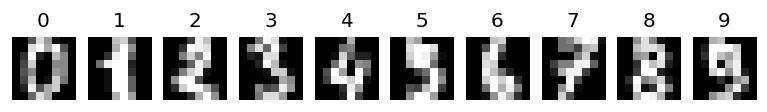

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

digits = load_digits()
X = digits.images
y = digits.target

plt.figure(figsize=(8,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X[i], cmap="gray")
    plt.title(y[i])
    plt.axis("off")
plt.show()

<br>

### **b. 搭建CNN模型：**

In [ ]:
X = X.astype(np.float32) / 16.0
X = X[:, None, :, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256)

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc   = nn.Linear(8*4*4, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)

model = SimpleCNN()
model

SimpleCNN(
  (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

<br>

### **c. 訓練CNN模型：**  

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    for xb,yb in train_loader:
        loss = loss_fn(model(xb), yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"epoch {epoch+1}, loss = {loss.item():.4f}")

epoch 1, loss = 0.9844
epoch 2, loss = 0.2872
epoch 3, loss = 0.2425
epoch 4, loss = 0.0838
epoch 5, loss = 0.2572
epoch 6, loss = 0.2884
epoch 7, loss = 0.1846
epoch 8, loss = 0.1997
epoch 9, loss = 0.2106
epoch 10, loss = 0.0786


<br>

### **d. 進行CNN預測：**  

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        pred = model(xb).argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

print("accuracy =", correct / total)

accuracy = 0.975


<br>

### **e. 訓練完模型後，我們來看看：**
👉 **第一層 CNN 眼中的世界**

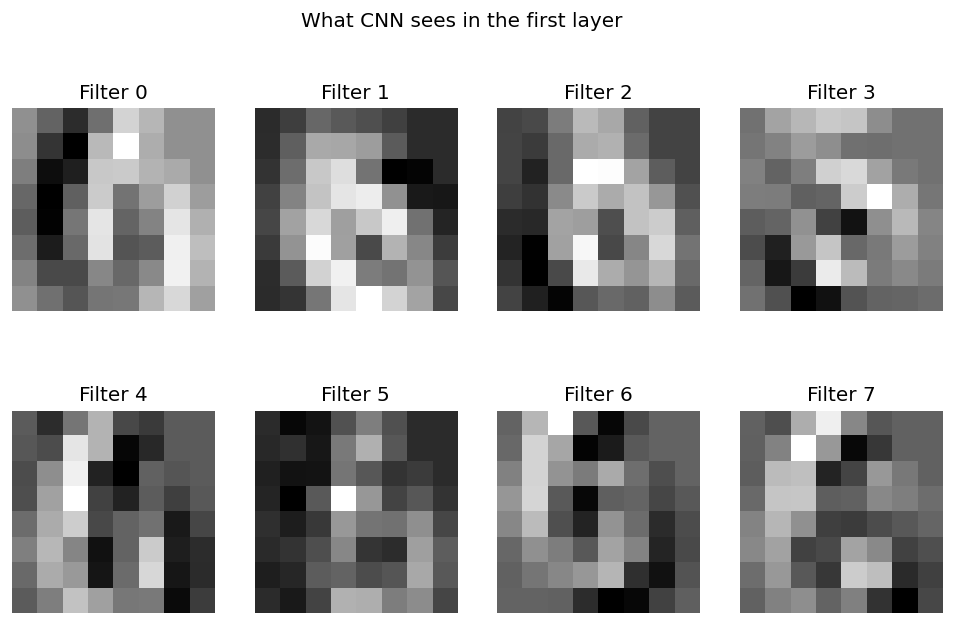

In [ ]:
sample = torch.tensor(X_test[0:1])
with torch.no_grad():
    fmap = model.conv(sample)[0].numpy()

fig = plt.figure(figsize=(10,6))
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(fmap[i], cmap="gray")
    ax.set_title(f"Filter {i}")
    ax.axis("off")

plt.suptitle("What CNN sees in the first layer")
plt.show()

<br>

# **恭喜!**
你已經初步了解CNN架構與原理!